In [1]:
import pandas as pd
import pickle as pickle
import numpy as np
from datetime import datetime
from datetime import date
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings; warnings.simplefilter('ignore')
import seaborn as sns

pd.set_option('display.max_columns', None)


### Conts 

In [2]:
# Background graph style
sns.set(style="darkgrid")
sns.set(style="whitegrid")


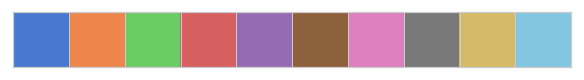

In [3]:
# ==============
# Chouse color
# ==============
sns.palplot(sns.color_palette("muted"))  # show color
sns.set_palette("muted") # for seaborn
colors = sns.color_palette("muted") # for pyplot

### Functions 

In [4]:
# ------------------------------- FUNCIONES ---------------------------------------- #

def woe(catvar,target, data):
    data_aggr = data.groupby([catvar,target]).size().reset_index()
    data_aggr.columns = [catvar,'target','numreg']
    
    # calculamos totales target
    non_event_total= np.sum(data_aggr[data_aggr.target==0]['numreg'])
    event_total = np.sum(data_aggr[data_aggr.target==1]['numreg']) 
    
    # pivoteamos data frame
    data_aggr = data_aggr.pivot(index=catvar, columns='target', values='numreg').reset_index()
    data_aggr.columns = [catvar,'non_event','event']
    
    # calculamos rate de event
    data_aggr['event_rate'] = data_aggr['event']/event_total
    data_aggr['non_event_rate'] = data_aggr['non_event']/non_event_total
    
    # calculamos woe
    data_aggr['woe'] = np.log(data_aggr['event_rate']/data_aggr['non_event_rate'])
    
    # calculamos IV
    data_aggr['rate_diff'] = data_aggr['event_rate'] - data_aggr['non_event_rate']
    data_aggr['information_value'] = data_aggr['rate_diff']*data_aggr['woe']
    #data_aggr['IV'] = data_aggr['IV'].sum()
    
    
    return data_aggr[[catvar,'woe','information_value','event_rate','non_event_rate']]

In [5]:
def info_value(woe_data):
    iv = woe_data['information_value'].sum()
    predictive_power = ""
    if iv < 0.02:
        predictive_power = "useless for prediction"
    elif iv >= 0.02 and iv < 0.1:
        predictive_power = "weak predictor"
    elif iv >= 0.1 and iv < 0.3:
        predictive_power = "medium predictor"
    elif iv >= 0.3 and iv < 0.5:
        predictive_power = "strong predictor"
    else:
        predictive_power = "suspicious predictor"
        
    return iv,predictive_power

In [6]:
def barprop(yvalue, xvalue, stitle, size, data):
    table=pd.crosstab(data[xvalue],data[yvalue])
    ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=size)
    
    
    if len(stitle)==0: # default title
        stitle = "Proportion bar graph"
    
    plt.title(stitle)
    plt.xlabel(xvalue)
    plt.ylabel(yvalue)
    plt.legend(data[yvalue].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pass

In [7]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

In [8]:
# =========================
#  Histogram
# =========================
def simpleHistGraph(numvar,  data, bins=10):
    g = data[numvar].hist(bins=bins)
    g.set_title(numvar +" distribucion ")
    pass

In [9]:
def countBarPlot(catvar, data, scale="linear", orient="h", rot=0, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    g = sns.countplot(x = catvar, data=data, orient=orient)
    loc, labels = plt.xticks()
    g.set_xticklabels(labels, rotation=rot)
    g.set_yscale(scale)
    
    g.set_title("Number of cases by " + catvar.upper())
    plt.show()
    pass

### base_inicial_train

- codtarget : indica si el cliente contactado adquirió una TC en el mes
- margen : rentabilidad esperada de ese cliente menos los costos de gestion
- cem : capacidad de endeudamiento
- ingreso_neto : ingreso estimado
- lines_ofrecida : linea ofertada

#### Load Data

In [10]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_inicial_train/ib_base_inicial_train.csv',sep=',')

In [11]:
y_train = rawdata[['codmes', 'id_persona', 'margen','codtarget']].copy()
y_train["target"] = (y_train["margen"] > 0).astype(int)


In [12]:
y_train = y_train.groupby(['id_persona']).target.max().reset_index()

In [23]:
rawdata["target"] = (rawdata["margen"] > 0).astype(int)

#### Describe Data

In [13]:
rawdata.shape

(212665, 7)

In [14]:
rawdata.head()

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida
0,201901,165747,0,-5.00,1.0,1781.0,1700
1,201903,100117,0,-5.00,478.0,2106.0,2100
2,201901,65751,1,342.99,687.0,3083.0,4600
3,201901,58047,0,-5.00,182.0,1814.0,3600
4,201901,113221,0,-5.00,582.0,2153.0,4300


In [15]:
rawdata.sample(n=5)

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida
75469,201901,252035,0,-5.0,572.0,2061.0,1000
134893,201902,203427,0,-5.0,394.0,2630.0,5200
12026,201903,161427,0,-5.0,605.0,2662.0,5300
30807,201904,104152,0,-5.0,1803.0,3574.0,7100
182476,201903,171630,0,-5.0,1384.0,4927.0,9800


In [16]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212665 entries, 0 to 212664
Data columns (total 7 columns):
codmes            212665 non-null int64
id_persona        212665 non-null int64
codtarget         212665 non-null int64
margen            212665 non-null float64
cem               212665 non-null float64
ingreso_neto      212665 non-null float64
linea_ofrecida    212665 non-null int64
dtypes: float64(3), int64(4)
memory usage: 11.4 MB


In [17]:
rawdata.describe() # numerical data

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida
count,212665.000000,212665.000000,212665.000000,212665.000000,212665.000000,212665.000000,212665.000000
mean,201902.556881,127773.211173,0.145638,7.534526,867.481424,3136.008953,8100.679002
std,1.149051,73075.565353,0.352743,70.209438,1075.129778,2492.327322,10970.943116
min,201901.000000,1.000000,0.000000,-728.990000,0.000000,653.000000,700.000000
25%,201901.000000,63944.000000,0.000000,-5.000000,344.000000,1889.000000,1700.000000
50%,201903.000000,128109.000000,0.000000,-5.000000,650.000000,2662.000000,4200.000000
75%,201904.000000,190473.000000,0.000000,-5.000000,1064.000000,3467.000000,9800.000000
max,201904.000000,256375.000000,1.000000,4687.022200,61709.000000,109531.000000,100000.000000


In [18]:
print(rawdata.nunique())

codmes                 4
id_persona        165854
codtarget              2
margen             16985
cem                 6173
ingreso_neto        9335
linea_ofrecida       871
dtype: int64


In [19]:
print(rawdata.isnull().sum())

codmes            0
id_persona        0
codtarget         0
margen            0
cem               0
ingreso_neto      0
linea_ofrecida    0
dtype: int64


In [127]:
rawdata['date'] = pd.to_datetime(rawdata['codmes'], format='%Y%m', errors='ignore').dt.date

#### Explore Numerical Data

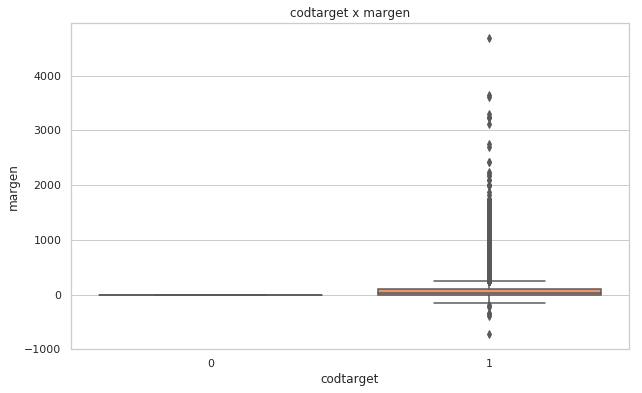

In [130]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='codtarget', y="margen", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("codtarget x margen")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

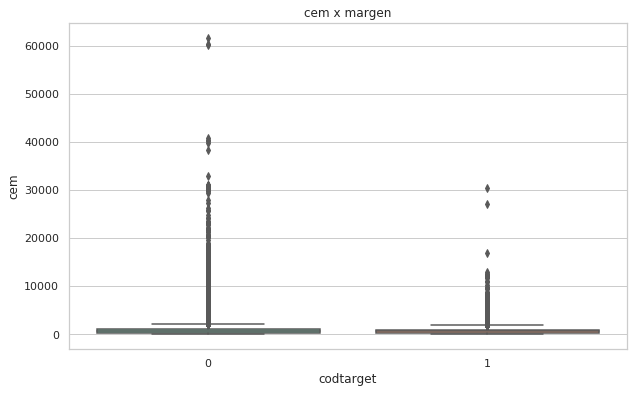

In [31]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="codtarget", y="cem", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("cem x margen")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

In [23]:
rawdata[rawdata.id_persona == 253581]

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida,date
279,201904,253581,1,-4.32,248.0,5506.0,8200,2019-04-01
1805,201901,253581,0,-5.00,578.0,6730.0,3300,2019-01-01


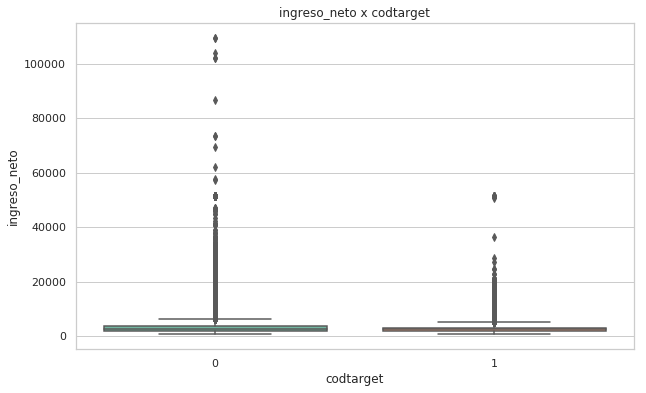

In [32]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="codtarget", y="ingreso_neto", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("ingreso_neto x codtarget")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

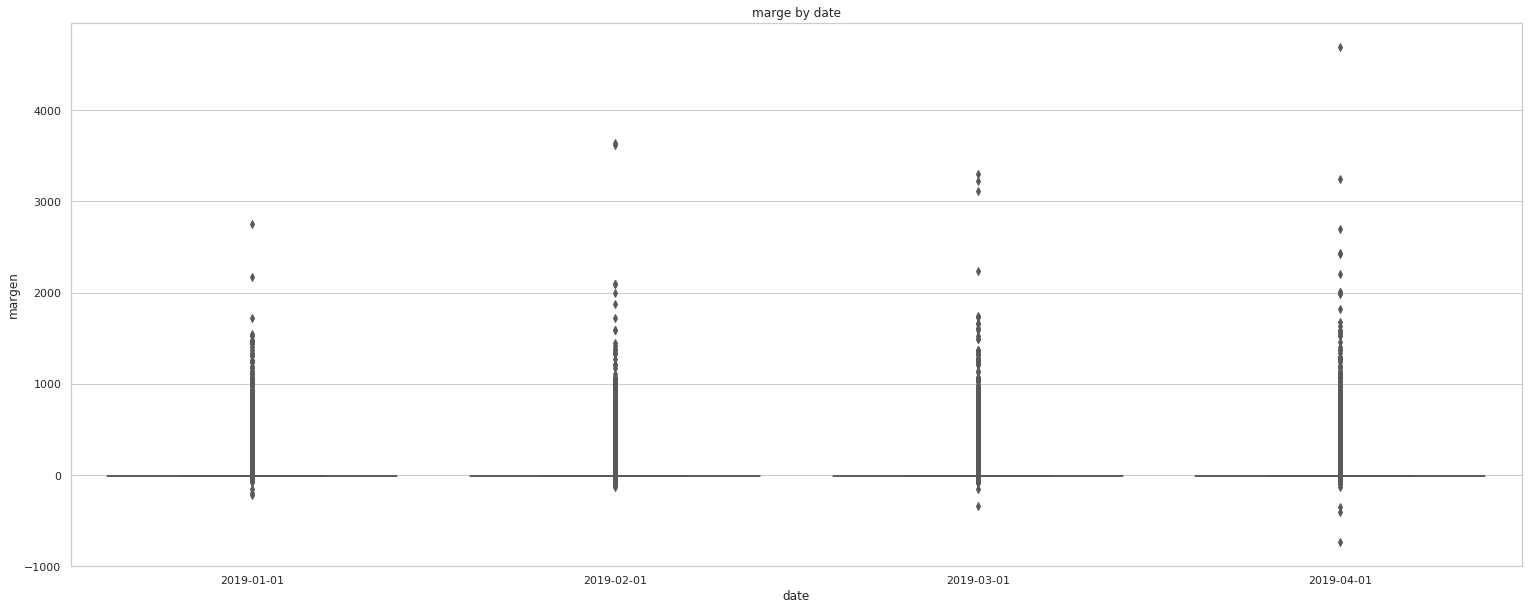

In [29]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.boxplot(x="date", y="margen", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('date')) # DataFrame, array, or list of arrays, optional
ax.set_title("marge by date")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

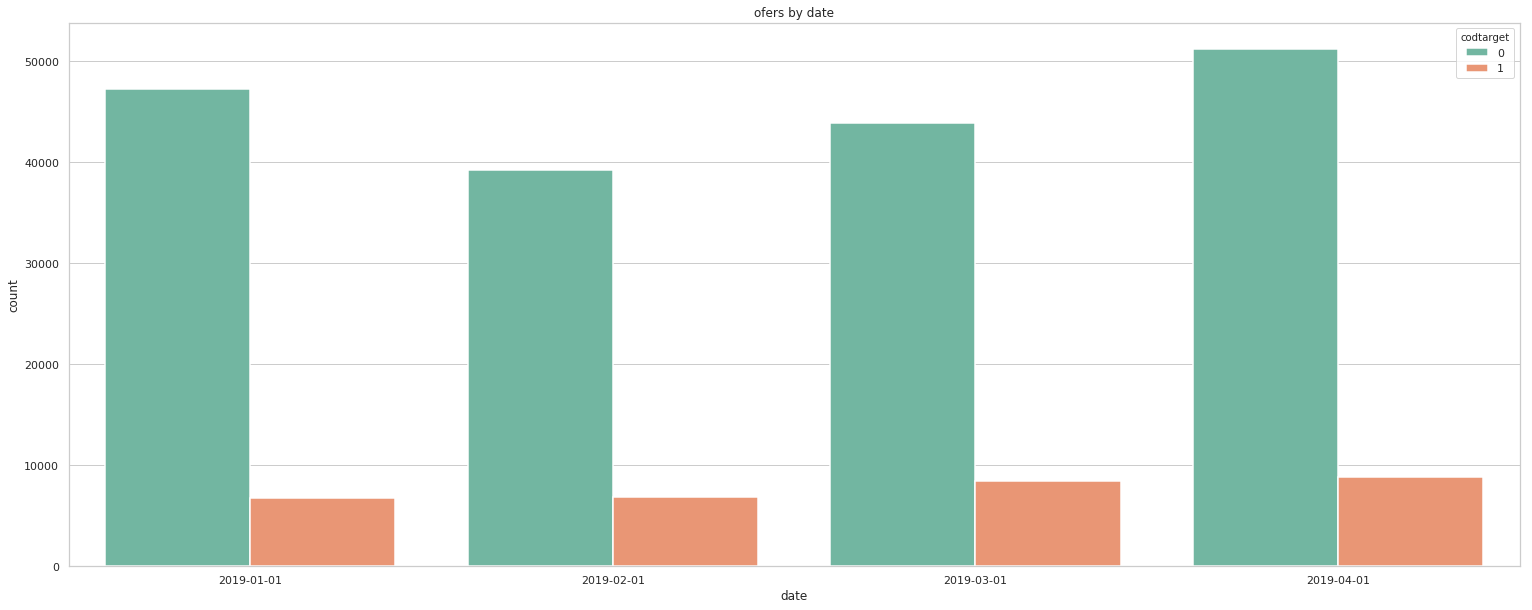

In [30]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(26, 10))
ax = sns.countplot(x="date",  hue='codtarget',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('date'))
ax.set_title("ofers by date")
pass

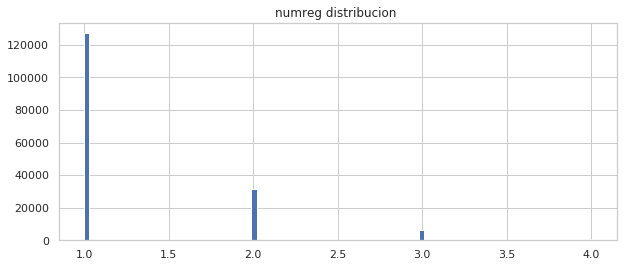

In [131]:
rawdata_agg = rawdata.groupby(['id_persona']).size().reset_index()
rawdata_agg.columns = ['id_persona','numreg']

plt.figure(figsize=(10, 4))
simpleHistGraph('numreg',rawdata_agg, bins=100)

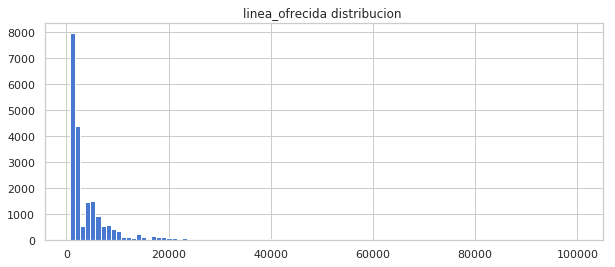

In [24]:
plt.figure(figsize=(10, 4))
simpleHistGraph('linea_ofrecida',rawdata[rawdata.target==1], bins=100)

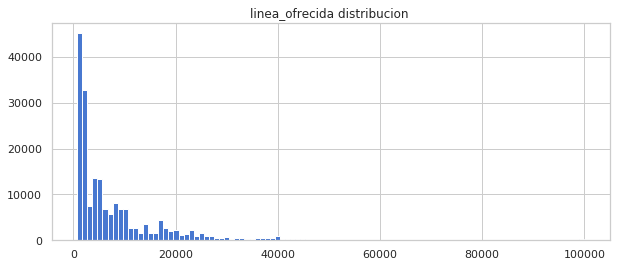

In [26]:
plt.figure(figsize=(10, 4))
simpleHistGraph('linea_ofrecida',rawdata[rawdata.target==0], bins=100)

### base_sunat

- activ_econo: grupo de actividad económica del RUC de la persona
- meses_alta: numero de meses de vigencia en dicha actividad hasta fin del 2018


#### Load Data

In [27]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_sunat/ib_base_sunat.csv',sep=',')

In [28]:
rawdata = pd.merge(rawdata, y_train, how='inner', on='id_persona')

#### Describe Data

In [29]:
rawdata.shape

(129399, 4)

In [30]:
rawdata.head()

,id_persona,activ_econo,meses_alta,target
0,174454,Grupo_11,70,0
1,245154,Grupo_15,27,1
2,1211,Grupo_07,20,0
3,87697,Grupo_07,55,0
4,70484,Grupo_15,33,0


In [31]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129399 entries, 0 to 129398
Data columns (total 4 columns):
id_persona     129399 non-null int64
activ_econo    129399 non-null object
meses_alta     129399 non-null int64
target         129399 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.9+ MB


In [32]:
rawdata.describe() # numerical data

,id_persona,meses_alta,target
count,129399.000000,129399.000000,129399.000000
mean,124472.340234,115.036005,0.128672
std,72394.773645,78.022370,0.334838
min,1.000000,1.000000,0.000000
25%,61086.500000,52.000000,0.000000
50%,123278.000000,97.000000,0.000000
75%,185362.500000,163.000000,0.000000
max,256375.000000,975.000000,1.000000


In [33]:
print(rawdata.nunique())

id_persona     129284
activ_econo        18
meses_alta        462
target              2
dtype: int64


In [34]:
print(rawdata.isnull().sum())

id_persona     0
activ_econo    0
meses_alta     0
target         0
dtype: int64


In [35]:
pd.merge(rawdata, y_train, how='right', on='id_persona').isnull().sum()

id_persona         0
activ_econo    36570
meses_alta     36570
target_x       36570
target_y           0
dtype: int64

#### Explore Numerical Data

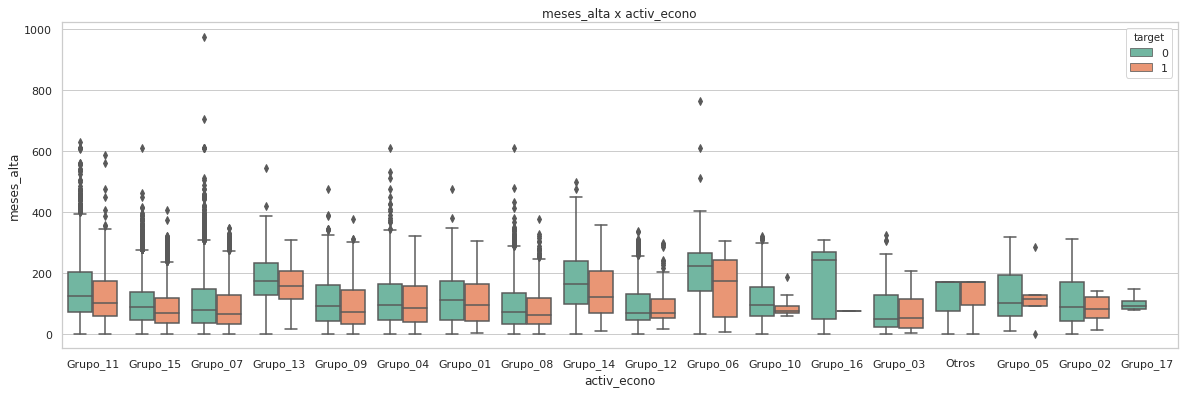

In [36]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 6))
ax = sns.boxplot(x="activ_econo", y="meses_alta", 
                hue = "target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("meses_alta x activ_econo")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

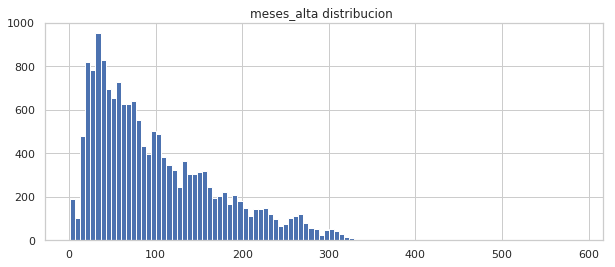

In [37]:
plt.figure(figsize=(10, 4))
simpleHistGraph('meses_alta',rawdata[rawdata.target == 1], bins=100)

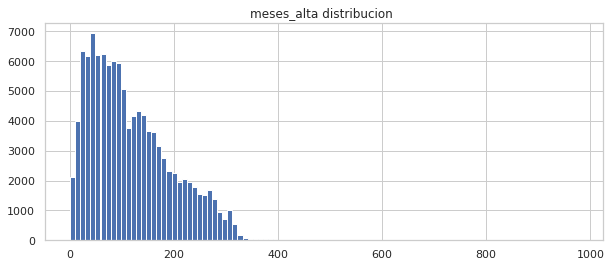

In [38]:
plt.figure(figsize=(10, 4))
simpleHistGraph('meses_alta',rawdata[rawdata.target == 0], bins=100)

In [40]:
info_value(woe('activ_econo','target',rawdata))

(0.0215045791677564, 'weak predictor')

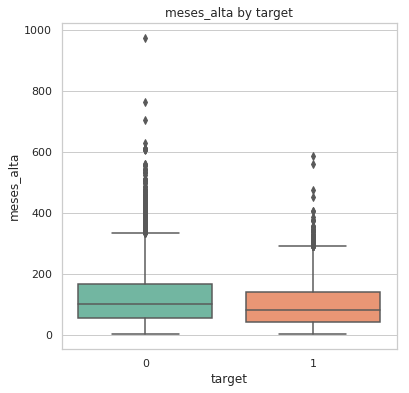

In [41]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="meses_alta", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("meses_alta by target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

### base_vehicular

- marca : marca del vehiculo
- veh_var1 : variable vehicular 1
- veh_var2 : variable vehicular 2

#### Load Data

In [42]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_vehicular/ib_base_vehicular.csv',sep=',')

In [43]:
rawdata = pd.merge(rawdata, y_train, how='inner', on='id_persona')

#### Describe Data

In [44]:
rawdata.shape

(52541, 5)

In [45]:
rawdata.head()

,id_persona,marca,veh_var1,veh_var2,target
0,14908,ACURA,0.942857,3376.0,1
1,227555,ADVANCE,0.985714,3426.0,0
2,211938,AKT,1.000000,3426.0,0
3,20772,ALESIN,0.985714,3424.0,0
4,20772,DAEWOO,0.942857,3388.0,0


In [46]:
rawdata.marca.unique()

array(['ACURA', 'ADVANCE', 'AKT', 'ALESIN', 'DAEWOO', 'JAC', 'MITSUBISHI',
       'ARGOS', 'SAKIMOTO', 'FIBRASA', 'ARO', 'KIA MOTORS', 'RONCO',
       'TOYOTA', 'BAJAJ', 'ARTSUN', 'DATSUN', 'JMSTAR', "ASESOR MOTOR'S",
       'ASIA', 'OPEL', 'MAZDA', 'NISSAN', 'ASIA MOTORS', 'AUDI',
       'HYUNDAI', 'BMW', 'CHEVROLET', 'PONTIAC', 'KIA', 'MERCEDES BENZ',
       'PORSCHE', 'VOLVO', 'JEEP', 'AUSTIN', 'BAIC YINXIANG', 'BAJA',
       'BAW', 'HONDA', 'ITALIKA', 'KAMAX', 'LAM', 'CHERY', 'JR',
       'VICTORIA MOTORÂ´S', 'BAODIAO', 'TVS', 'PIAGGIO', 'KTM', 'HERO',
       'BASHAN', 'VOLKSWAGEN', 'BRILLIANCE', 'BYD', 'CF MOTO', 'LADA',
       'CHANGAN', 'CHANGHE', 'RENAULT', 'YUMBO', 'SUZUKI', 'HAFEI',
       'HILLMAN', 'PEUGEOT', 'DAIHATSU', 'FORD', 'CITROEN', 'LX-POWER',
       'CMC', 'HINO', 'CORENHA', 'INTERNATIONAL', 'RECSA', 'CORLUSA',
       'MOTOKAR', 'CUSO', 'CYCLER', 'DAELIM HONDA', 'JINBEI', 'RTM',
       'ZOTYE', 'DAVEST', 'DFSK', 'DIM', 'DODGE', 'SCANIA', 'DONGFENG',
       "SENLY M

In [48]:
info_value(woe('marca','target',rawdata))

(0.06874546835792303, 'weak predictor')

In [47]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52541 entries, 0 to 52540
Data columns (total 5 columns):
id_persona    52541 non-null int64
marca         52507 non-null object
veh_var1      49544 non-null float64
veh_var2      50589 non-null float64
target        52541 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.4+ MB


In [156]:
rawdata.describe() # numerical data

,id_persona,veh_var1,veh_var2,target
count,52541.000000,49544.000000,50589.000000,52541.000000
mean,90397.821701,0.944869,3405.919706,0.078605
std,62297.390112,0.049015,22.493033,0.269124
min,24.000000,0.000000,3258.000000,0.000000
25%,37552.000000,0.942857,3392.000000,0.000000
50%,77860.000000,0.942857,3414.000000,0.000000
75%,134221.000000,0.957143,3424.000000,0.000000
max,256369.000000,1.000000,3432.000000,1.000000


In [157]:
print(rawdata.nunique())

id_persona    34935
marca           510
veh_var1         56
veh_var2         79
target            2
dtype: int64


In [158]:
pd.merge(rawdata, y_train, how='right', on='id_persona').isnull().sum()

id_persona         0
marca         130953
veh_var1      133916
veh_var2      132871
target_x      130919
target_y           0
dtype: int64

#### Explore Numerical Data

<Figure size 864x864 with 0 Axes>

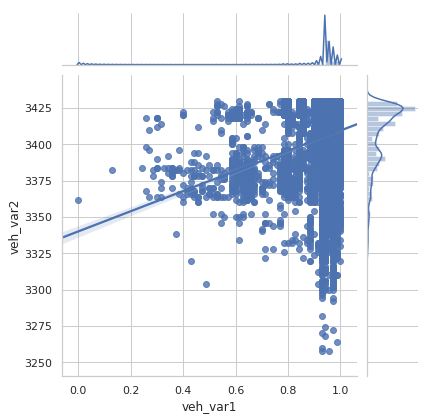

In [54]:
# =======================================
#  Scater plot + distribution + line reg
#  2 numerical vars
# =======================================
plt.figure(figsize=(12,12))
sns.jointplot("veh_var1", "veh_var2", data=rawdata, kind="reg", annot_kws=dict(stat="r"))
pass

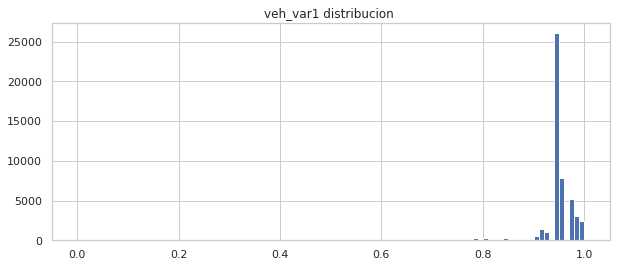

In [55]:
plt.figure(figsize=(10, 4))
simpleHistGraph('veh_var1',rawdata, bins=100)

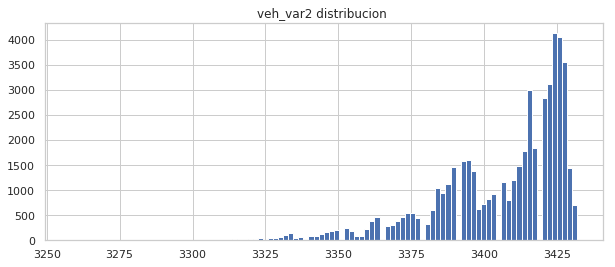

In [56]:
plt.figure(figsize=(10, 4))
simpleHistGraph('veh_var2',rawdata, bins=100)

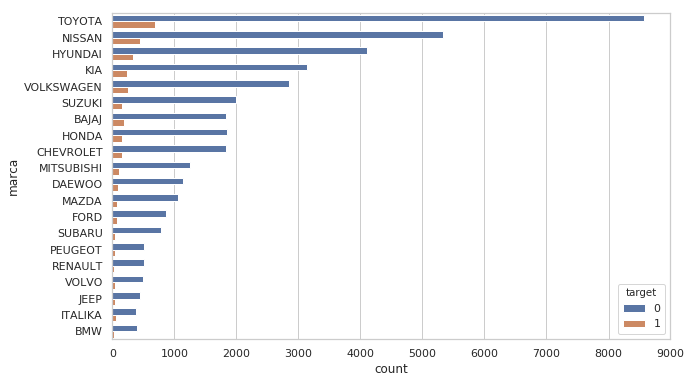

In [62]:
plt.figure(figsize=(10, 6))
sns.countplot(y="marca", hue="target", data=rawdata, 
              order=rawdata.marca.value_counts().iloc[:20].index)
pass

### base_reniec

- soc_var1 : variable sociodemográfica 1
- soc_var2 : variable sociodemográfica 2
- soc_var3 : variable sociodemográfica 3
- soc_var4 : variable sociodemográfica 4
- soc_var5 : variable sociodemográfica 5
- soc_var6 : variable sociodemográfica 6

#### Load Data

In [49]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_reniec/ib_base_reniec.csv',sep=',')

In [50]:
rawdata = pd.merge(rawdata, y_train, how='inner', on='id_persona')

#### Describe Data

In [51]:
rawdata.shape

(165846, 8)

In [52]:
rawdata.head()

,id_persona,soc_var1,soc_var2,soc_var3,soc_var4,soc_var5,soc_var6,target
0,94514,0.490566,4,2,6,5,10.0,0
1,55357,0.584906,4,2,6,5,1.0,0
2,79861,0.603774,4,1,6,5,9.0,0
3,59001,0.603774,3,2,6,5,2.0,0
4,64401,0.283019,4,1,6,5,11.0,0


In [53]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165846 entries, 0 to 165845
Data columns (total 8 columns):
id_persona    165846 non-null int64
soc_var1      165846 non-null float64
soc_var2      165846 non-null int64
soc_var3      165846 non-null int64
soc_var4      165846 non-null int64
soc_var5      165846 non-null int64
soc_var6      158860 non-null float64
target        165846 non-null int64
dtypes: float64(2), int64(6)
memory usage: 11.4 MB


In [54]:
rawdata.describe() # numerical data

,id_persona,soc_var1,soc_var2,soc_var3,soc_var4,soc_var5,soc_var6,target
count,165846.000000,165846.000000,165846.000000,165846.000000,165846.000000,165846.000000,158860.000000,165846.000000
mean,126662.732885,0.635597,3.657339,1.523003,5.348456,4.508357,5.561243,0.125351
std,73222.193891,0.218562,0.558366,0.499472,1.611437,1.221966,3.112714,0.331118
min,1.000000,0.018868,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,62844.250000,0.490566,3.000000,1.000000,6.000000,5.000000,3.000000,0.000000
50%,126340.000000,0.679245,4.000000,2.000000,6.000000,5.000000,5.000000,0.000000
75%,189302.750000,0.811321,4.000000,2.000000,6.000000,5.000000,8.000000,0.000000
max,256375.000000,1.000000,4.000000,2.000000,6.000000,5.000000,11.000000,1.000000


In [55]:
print(rawdata.nunique())

id_persona    165846
soc_var1          53
soc_var2           4
soc_var3           2
soc_var4           6
soc_var5           5
soc_var6          11
target             2
dtype: int64


#### Explore  Data

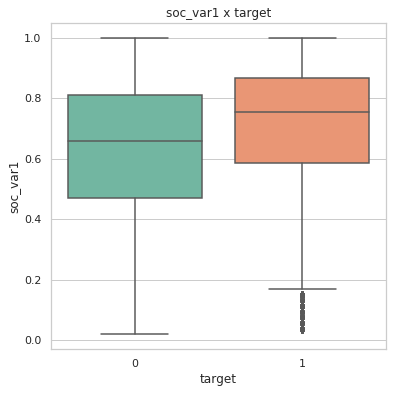

In [71]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="soc_var1", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("soc_var1 x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

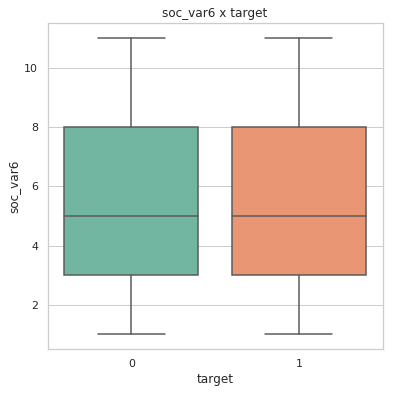

In [72]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="soc_var6", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("soc_var6 x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

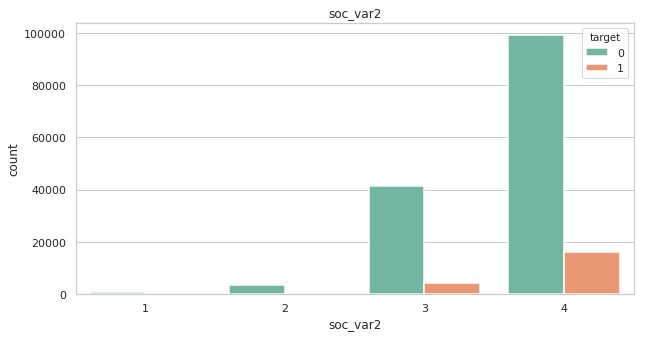

In [74]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="soc_var2",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('soc_var2'))
ax.set_title("soc_var2")
pass

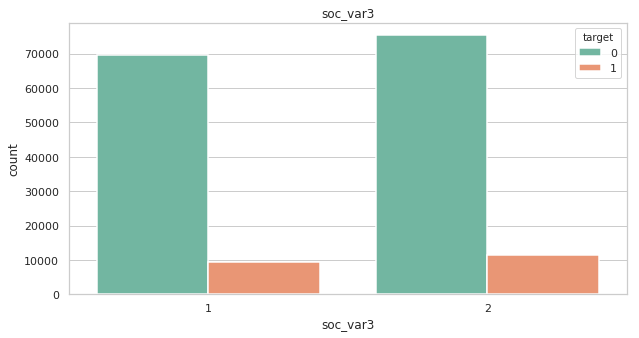

In [75]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="soc_var3",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('soc_var3'))
ax.set_title("soc_var3")
pass

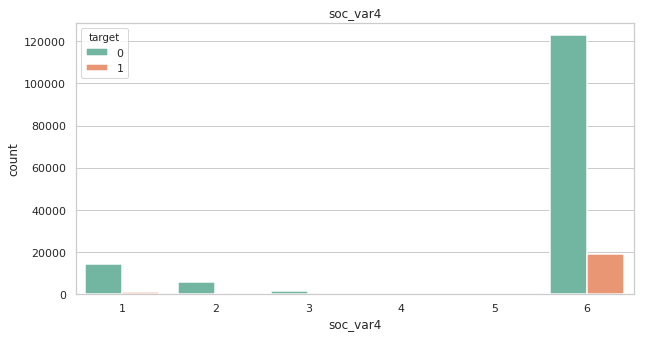

In [76]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="soc_var4",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('soc_var4'))
ax.set_title("soc_var4")
pass

#### woe

In [56]:
info_value(woe('soc_var2','target',rawdata))


(0.04218369008821805, 'weak predictor')

In [57]:
info_value(woe('soc_var3','target',rawdata))


(0.003615323526474648, 'useless for prediction')

In [58]:
info_value(woe('soc_var4','target',rawdata))


(0.05960795369514311, 'weak predictor')

In [59]:
info_value(woe('soc_var5','target',rawdata))


(0.056690241392767654, 'weak predictor')

In [60]:
info_value(woe('soc_var6','target',rawdata))


(0.03984697566537514, 'weak predictor')

### base_campanias

- prodcuto : producto que se le ofrecio al cliente en la campaña
- canal_asignado : cananl asignado para la venta/contacto


#### Load Data

In [13]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_campanias/ib_base_campanias.csv',sep=',')

In [78]:
rawdata = pd.merge(rawdata, y_train, how='inner', on='id_persona')

#### Describe Data

In [79]:
rawdata.shape

(3460746, 5)

In [80]:
rawdata.head()

,codmes,id_persona,producto,canal_asignado,target
0,201801,213598,Adelanto de Sueldo,RED DE TIENDAS,0
1,201801,213598,Adquisición TC,RED DE TIENDAS,0
2,201801,213598,Préstamo Express,GT,0
3,201802,213598,Adelanto de Sueldo,RED DE TIENDAS,0
4,201802,213598,Adquisición TC,TELEVENTAS,0


In [81]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460746 entries, 0 to 3460745
Data columns (total 5 columns):
codmes            int64
id_persona        int64
producto          object
canal_asignado    object
target            int64
dtypes: int64(3), object(2)
memory usage: 158.4+ MB


In [82]:
rawdata.describe() # numerical data

,codmes,id_persona,target
count,3.460746e+06,3.460746e+06,3.460746e+06
mean,2.018315e+05,1.227665e+05,5.866539e-02
std,4.121660e+01,6.859376e+04,2.349974e-01
min,2.018010e+05,1.000000e+00,0.000000e+00
25%,2.018060e+05,6.154700e+04,0.000000e+00
50%,2.018100e+05,1.244800e+05,0.000000e+00
75%,2.019010e+05,1.788020e+05,0.000000e+00
max,2.019040e+05,2.563750e+05,1.000000e+00


In [83]:
print(rawdata.nunique())

codmes                16
id_persona        159358
producto              59
canal_asignado        37
target                 2
dtype: int64


#### Explore  Data

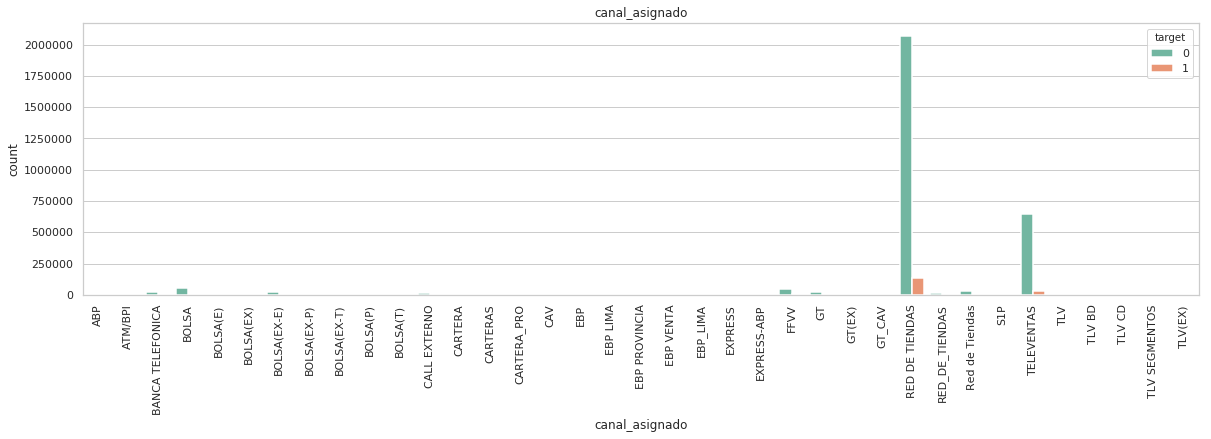

In [86]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="canal_asignado",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('canal_asignado'))
ax.set_title("canal_asignado")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

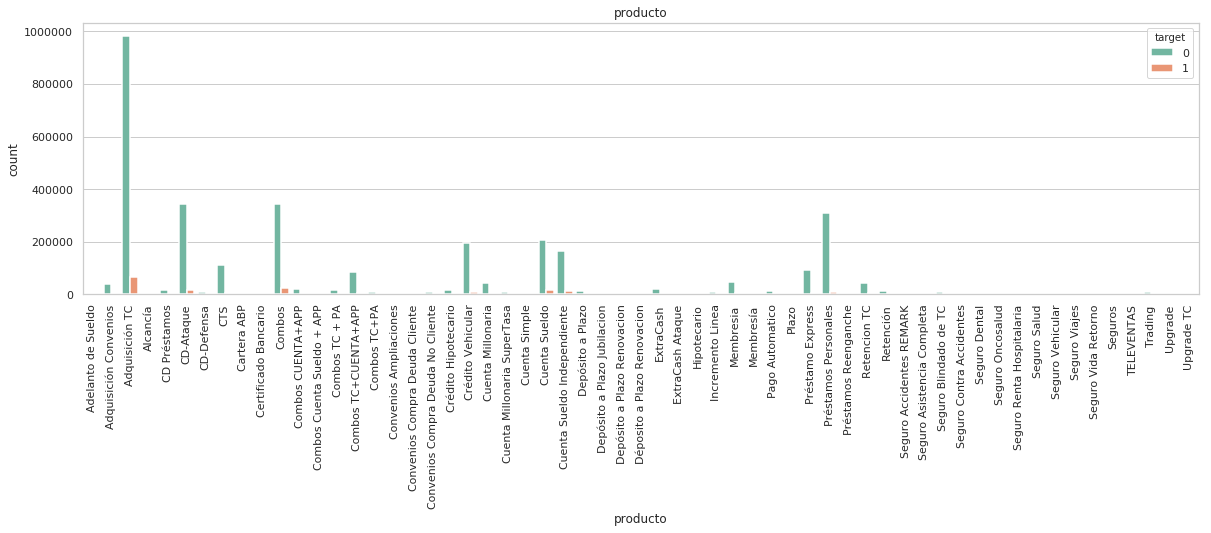

In [87]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="producto",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('producto'))
ax.set_title("producto")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

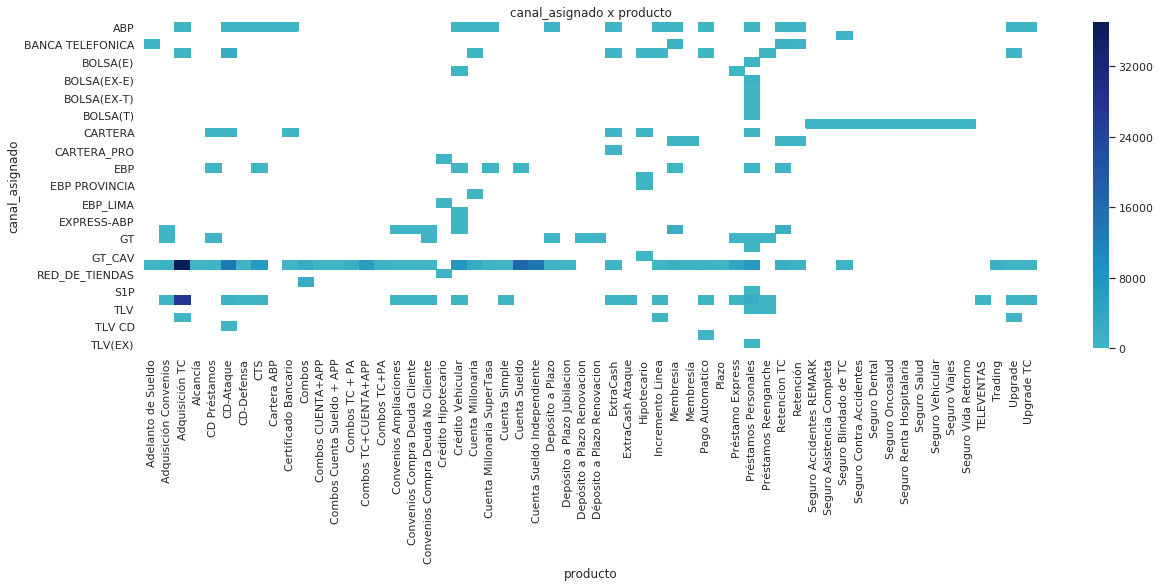

In [92]:
plt.figure(figsize=(20,6))
df = rawdata.pivot_table(index='canal_asignado', columns='producto', 
                         values='target', 
                         aggfunc=np.count_nonzero) # chouse a math function from numpy
ax = sns.heatmap(df, annot=False, fmt=".1f",cmap="YlGnBu",center=0)
ax.set_title("canal_asignado x producto")
plt.show()

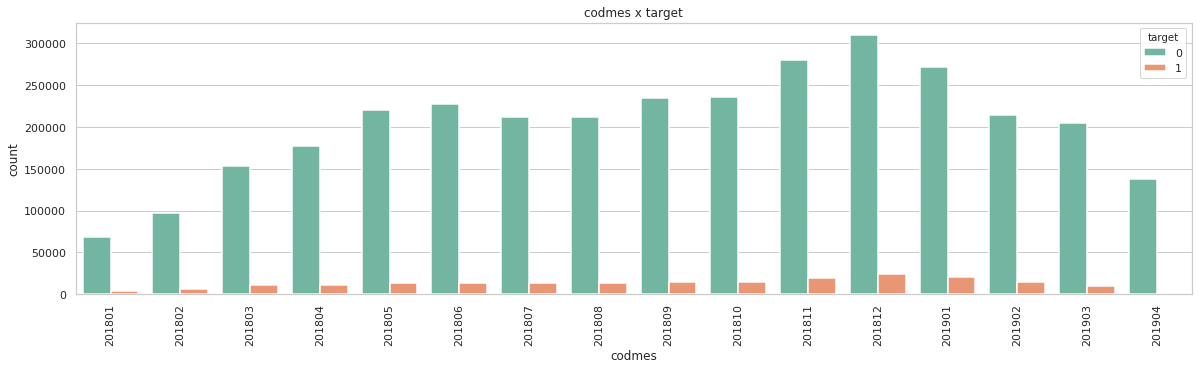

In [93]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="codmes",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('codmes'))
ax.set_title("codmes x target")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

### base_rcc

- cod_banco : entidad financiera con la que el cliente tiene un saldo
- producto : producto que el cliente tiene en la entidad
- clasif : clasificacion de riesgo en dicho producto-entidad
- mto_saldo : saldo que tiene en dicho producto-entidad
- rango_mora : rango de sus dias de mora en el producto-entidad


#### Load Data

In [13]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_rcc/ib_base_rcc.csv',sep=',')

In [14]:
rawdata = pd.merge(rawdata, y_train, how='inner', on='id_persona')

#### Describe Data

In [15]:
rawdata.shape

(8273810, 8)

In [16]:
rawdata.head()

,codmes,id_persona,cod_banco,producto,clasif,mto_saldo,rango_mora,target
0,201811,10155,29,PRESTAMOS COMERCIALES,0.0,36698.4870,1.0,0
1,201809,10155,29,HIPOTECARIO REGULAR,0.0,49534.4274,1.0,0
2,201901,10155,29,HIPOTECARIO REGULAR,0.0,44366.4946,1.0,0
3,201810,10155,29,HIPOTECARIO REGULAR,0.0,48290.0256,1.0,0
4,201903,10155,29,PRESTAMOS COMERCIALES,0.0,32631.9928,1.0,0


In [17]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8273810 entries, 0 to 8273809
Data columns (total 8 columns):
codmes        int64
id_persona    int64
cod_banco     int64
producto      object
clasif        float64
mto_saldo     float64
rango_mora    float64
target        int64
dtypes: float64(3), int64(4), object(1)
memory usage: 568.1+ MB


In [20]:
rawdata.describe() # numerical data

,codmes,id_persona,cod_banco,clasif,mto_saldo,rango_mora,target
count,8.273810e+06,8.273810e+06,8.273810e+06,4.824128e+06,8.273810e+06,4.824128e+06,8.273810e+06
mean,2.018160e+05,1.168203e+05,3.373438e+01,2.108008e-02,7.253537e+03,1.056505e+00,1.005301e-01
std,3.536323e+01,6.990193e+04,1.788599e+01,1.436514e-01,3.081032e+04,3.890402e-01,3.007055e-01
min,2.017120e+05,1.000000e+00,1.000000e+00,0.000000e+00,7.300000e-03,1.000000e+00,0.000000e+00
25%,2.018040e+05,5.580600e+04,1.700000e+01,0.000000e+00,5.941324e+02,1.000000e+00,0.000000e+00
50%,2.018080e+05,1.140850e+05,3.600000e+01,0.000000e+00,1.774776e+03,1.000000e+00,0.000000e+00
75%,2.018110e+05,1.739070e+05,4.300000e+01,0.000000e+00,5.694000e+03,1.000000e+00,0.000000e+00
max,2.019030e+05,2.563750e+05,8.400000e+01,1.000000e+00,1.192650e+07,7.000000e+00,1.000000e+00


In [21]:
print(rawdata.nunique())

codmes             16
id_persona     154402
cod_banco          77
producto           29
clasif              2
mto_saldo     1555484
rango_mora          7
target              2
dtype: int64


In [28]:
rawdata.groupby(['id_persona','cod_banco']).producto.nunique().reset_index()

,id_persona,cod_banco,producto
0,1,14,3
1,1,36,2
2,1,40,1
3,1,52,1
4,1,66,1
5,2,28,5
6,2,75,1
7,3,20,2
8,3,24,3
9,3,36,4


#### Explore  Data

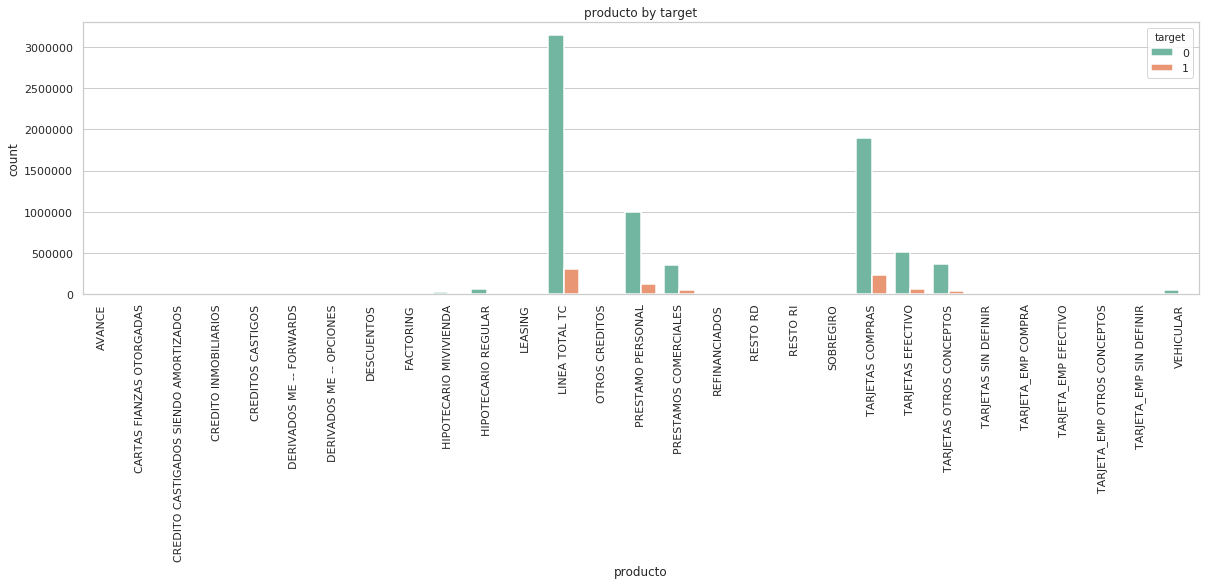

In [22]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="producto",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('producto'))
ax.set_title("producto​ by target")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

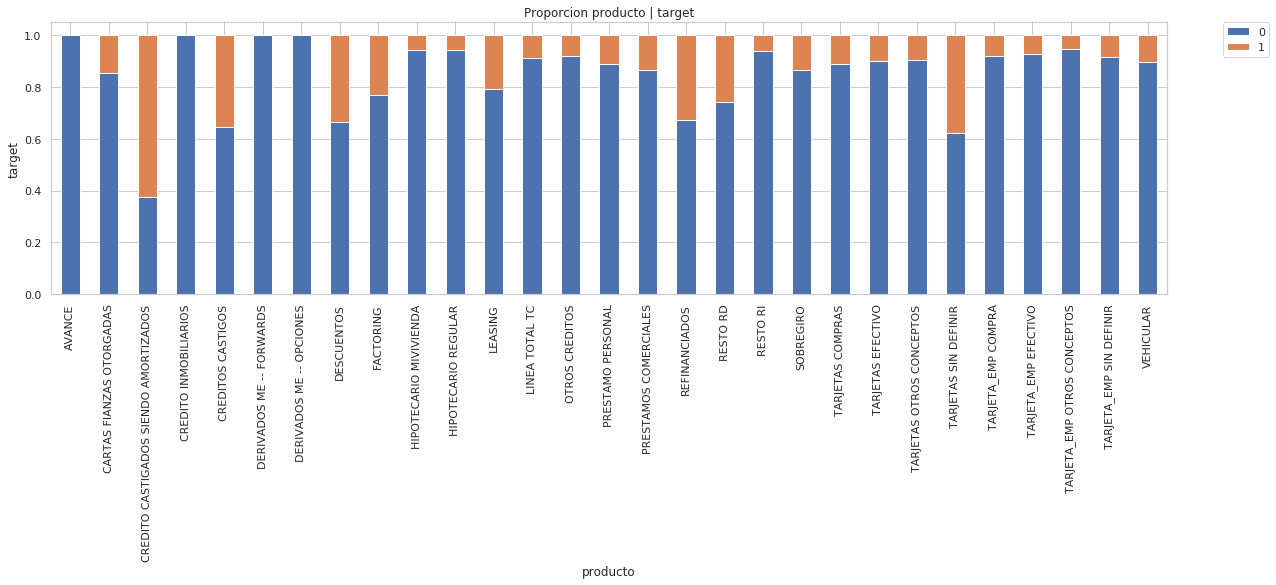

In [23]:
barprop('target', 'producto', 'Proporcion producto | target', (20,5), rawdata)

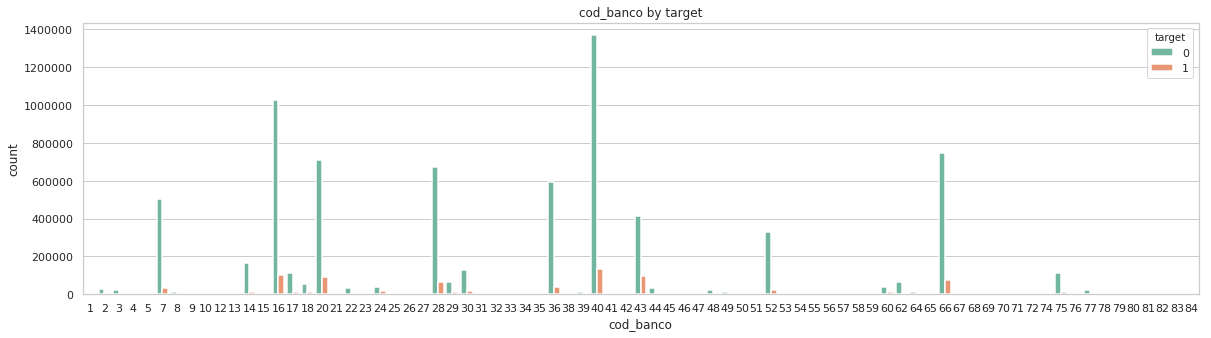

In [24]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="cod_banco",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('cod_banco'))
ax.set_title("cod_banco by target")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
pass

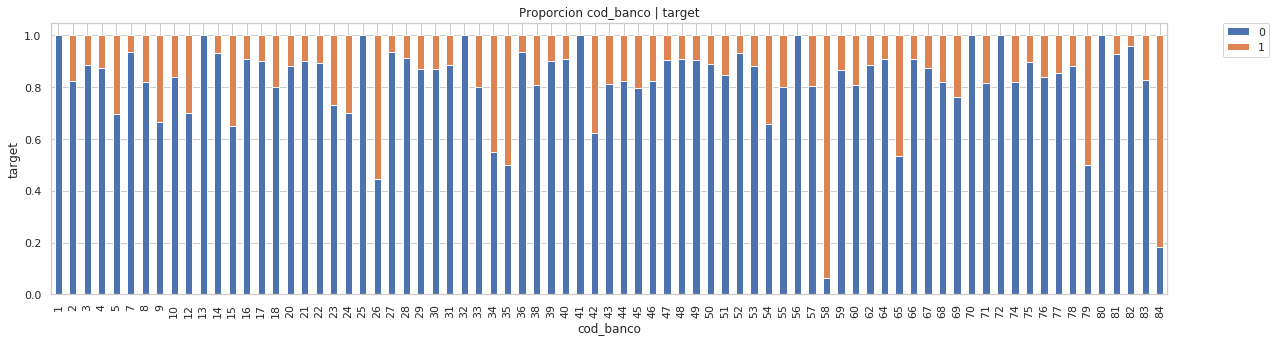

In [25]:
barprop('target', 'cod_banco', 'Proporcion cod_banco | target', (20,5), rawdata)

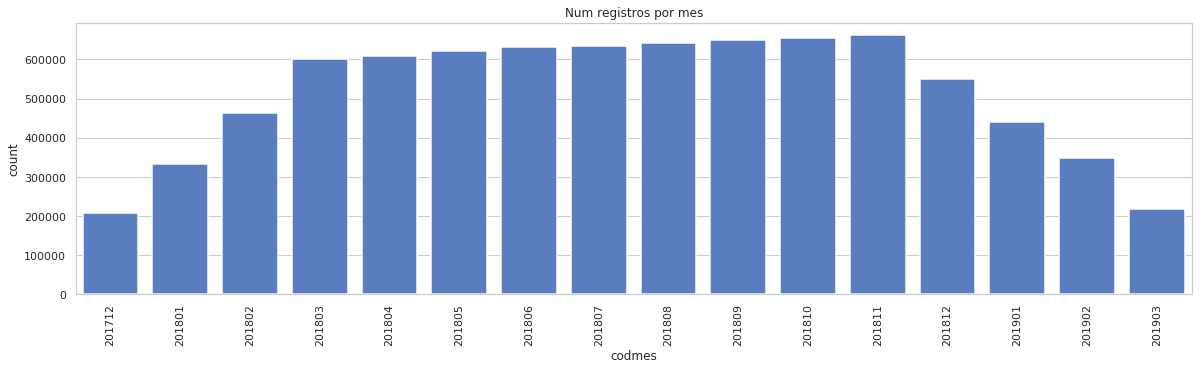

In [36]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="codmes", 
                   linewidth=1.5,
                 #palette="Oranges", # Colors to use for the different levels of the hue variable.
                 color=colors[0],
                   data=rawdata.sort_values('codmes'))
ax.set_title("Num registros por mes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

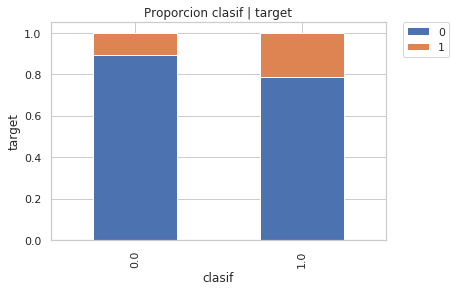

In [44]:
barprop('target', 'clasif', 'Proporcion clasif | target', (6,4), rawdata)

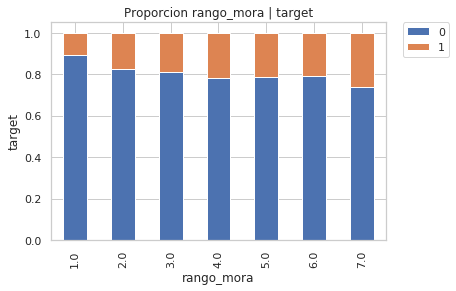

In [45]:
barprop('target', 'rango_mora', 'Proporcion rango_mora | target', (6,4), rawdata)

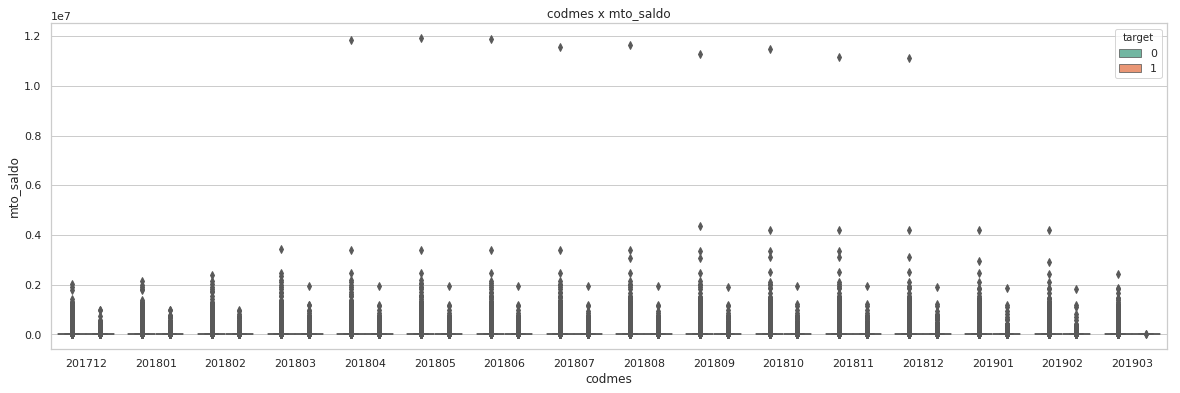

In [46]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 6))
ax = sns.boxplot(x="codmes", y="mto_saldo", 
                hue = "target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("codmes x mto_saldo")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

### base_digital

- simu_prestamo - numero de veces en el dia en que el cliente utilizó el simulador de préstamos
- benefit - numero de veces en el dia en que el cliente ingresó a la pagina de interbank benefit
- email - numero de veces en el dia en que el cliente arribó al sitio a traves de email
- facebook - numero de veces en el dia en que el cliente arribó al sitio a traves de facebook
- goog - numero de veces en el dia en que el cliente arribó al sitio a traves de google
- youtb - numero de veces en el dia en que el cliente arribó al sitio a traves de youtube
- compb - numero de veces en el dia en que el cliente arribó al sitio a traves de comparabien
- movil - numero de sesiones iniciadas en el movil
- desktop - numero de sesiones iniciadas en desktop
- n_rep30 - si ha tenido una sesion en los 30 dias previos
- recencia - variable categorica que indica hace cuanto fue su ultima sesion, donde 100 = primera sesion.
- lima_dig - si tuvo una visita desde lima
- provincia_dig - si tuvo una visita desde provincia
- extranjero_dig - si tuvo una visita desde el extranjero
- time_ctasimple - tiempo visitanto páginas referentes a cuenta simple
- time_mllp - tiempo visitanto páginas referentes a cuenta millonaria premia
- time_mllst - tiempo visitanto páginas referentes a cuenta millonaria super tasa
- time_ctasld - tiempo visitanto páginas referentes a cuenta sueldo
- time_tc - tiempo visitanto páginas referentes a tarjeta de credito
- n_sesion - numero de sesiones en el dia
- busqtc - utilizo el buscador para buscar información de TC
- busqvisa - utilizo el buscador para buscar información devisa
- busqamex - utilizo el buscador para buscar información de american express
- busqmc - utilizo el buscador para buscar información de master card
- busqcsimp - utilizo el buscador para buscar información de cuenta simple
- busqmll - utilizo el buscador para buscar información de cuenta millonaria
- busqcsld - utilizo el buscador para buscar información de cuenta sueldo
- busq - utilizo el buscador
- n_pag - numero de paginas visitadas en el dia
- android - Si uso android cual es su sistema operativo
- iphone - si uso iphone cual fue su sistema operativo

#### Load Data

In [28]:
# Load Train Data
rawdata = pd.read_csv('data/raw/ib_base_digital/ib_base_digital.csv',sep=',')

In [29]:
rawdata['codday'] = rawdata.codday.astype(int).astype(str)

In [30]:
rawdata['date'] = pd.to_datetime(rawdata['codday'], format='%Y%m%d', errors='ignore').dt.date

In [31]:
rawdata['codmes'] = pd.to_datetime(rawdata['codday'], format='%Y%m%d', errors='ignore').dt.strftime('%Y%m')

In [33]:
rawdata = pd.merge(rawdata, y_train, how='right', on='id_persona')

#### Describe Data

In [15]:
rawdata.shape

(312047, 34)

In [16]:
rawdata.head()

,codday,id_persona,simu_prestamo,benefit,email,facebook,goog,youtb,compb,movil,desktop,n_rep30,recencia,lima_dig,provincia_dig,extranjero_dig,time_ctasimple,time_mllp,time_mllst,time_ctasld,time_tc,n_sesion,busqtc,busqvisa,busqamex,busqmc,busqcsimp,busqmill,busqcsld,busq,n_pag,android,iphone,target
0,20181204.0,99258,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,NaN,0
1,20181102.0,99258,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,NaN,0
2,20181203.0,99258,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,8.0,NaN,0
3,20181118.0,99258,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,NaN,0
4,20190402.0,147297,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,NaN,0


In [69]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312047 entries, 0 to 312046
Data columns (total 34 columns):
codday            167587 non-null float64
id_persona        312047 non-null int64
simu_prestamo     167440 non-null float64
benefit           167587 non-null float64
email             167587 non-null float64
facebook          167587 non-null float64
goog              167587 non-null float64
youtb             167587 non-null float64
compb             167587 non-null float64
movil             167587 non-null float64
desktop           167587 non-null float64
n_rep30           167587 non-null float64
recencia          165880 non-null float64
lima_dig          167587 non-null float64
provincia_dig     167587 non-null float64
extranjero_dig    167587 non-null float64
time_ctasimple    167464 non-null float64
time_mllp         167587 non-null float64
time_mllst        167587 non-null float64
time_ctasld       167587 non-null float64
time_tc           167587 non-null float64
n_sesion 

In [70]:
rawdata.describe() # numerical data

,codday,id_persona,simu_prestamo,benefit,email,facebook,goog,youtb,compb,movil,desktop,n_rep30,recencia,lima_dig,provincia_dig,extranjero_dig,time_ctasimple,time_mllp,time_mllst,time_ctasld,time_tc,n_sesion,busqtc,busqvisa,busqamex,busqmc,busqcsimp,busqmill,busqcsld,busq,n_pag,android,iphone,target
count,1.675870e+05,312047.000000,167440.000000,167587.000000,167587.000000,167587.000000,167587.000000,167587.000000,167587.000000,167587.000000,167587.000000,167587.000000,165880.000000,167587.000000,167587.000000,167587.000000,167464.000000,167587.0,167587.0,167587.0,167587.0,167587.000000,167587.000000,167587.000000,167587.0,167587.0,167587.000000,167587.000000,167587.000000,167587.000000,167587.000000,77390.000000,8182.000000,312047.000000
mean,2.018876e+07,128945.454845,0.024767,0.022514,0.164679,0.209264,0.414370,0.001235,0.006558,0.637585,0.676138,0.572753,35.190463,0.776444,0.205344,0.023653,1.282174,0.0,0.0,0.0,0.0,1.313193,0.000036,0.000024,0.0,0.0,0.000280,0.000024,0.000078,0.001915,5.392954,7.230792,11.826326,0.097825
std,3.392591e+03,74470.185244,0.166545,0.186932,0.431085,0.469399,0.660133,0.036457,0.085105,0.727272,0.953076,0.494680,42.188566,0.416629,0.403954,0.151967,26.458139,0.0,0.0,0.0,0.0,0.777698,0.005983,0.004885,0.0,0.0,0.016744,0.004885,0.008807,0.043724,7.947887,1.091948,0.482705,0.297078
min,2.018110e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,7.000000,0.000000
25%,2.019012e+07,59915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,12.000000,0.000000
50%,2.019022e+07,131056.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,12.000000,0.000000
75%,2.019033e+07,194019.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,100.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,12.000000,0.000000
max,2.019042e+07,256375.000000,4.000000,9.000000,10.000000,6.000000,10.000000,2.000000,2.000000,10.000000,13.000000,1.000000,100.000000,1.000000,1.000000,1.000000,1953.000000,0.0,0.0,0.0,0.0,13.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,470.000000,9.000000,12.000000,1.000000


In [71]:
print(rawdata.nunique())

codday               170
id_persona        165854
simu_prestamo          5
benefit               10
email                  9
facebook               7
goog                  11
youtb                  3
compb                  3
movil                 11
desktop               13
n_rep30                2
recencia               5
lima_dig               2
provincia_dig          2
extranjero_dig         2
time_ctasimple       249
time_mllp              1
time_mllst             1
time_ctasld            1
time_tc                1
n_sesion              13
busqtc                 2
busqvisa               2
busqamex               1
busqmc                 1
busqcsimp              2
busqmill               2
busqcsld               2
busq                   2
n_pag                128
android                6
iphone                 5
target                 2
dtype: int64


In [72]:
print(rawdata.isnull().sum())

codday            144460
id_persona             0
simu_prestamo     144607
benefit           144460
email             144460
facebook          144460
goog              144460
youtb             144460
compb             144460
movil             144460
desktop           144460
n_rep30           144460
recencia          146167
lima_dig          144460
provincia_dig     144460
extranjero_dig    144460
time_ctasimple    144583
time_mllp         144460
time_mllst        144460
time_ctasld       144460
time_tc           144460
n_sesion          144460
busqtc            144460
busqvisa          144460
busqamex          144460
busqmc            144460
busqcsimp         144460
busqmill          144460
busqcsld          144460
busq              144460
n_pag             144460
android           234657
iphone            303865
target                 0
dtype: int64


#### Explore  Data

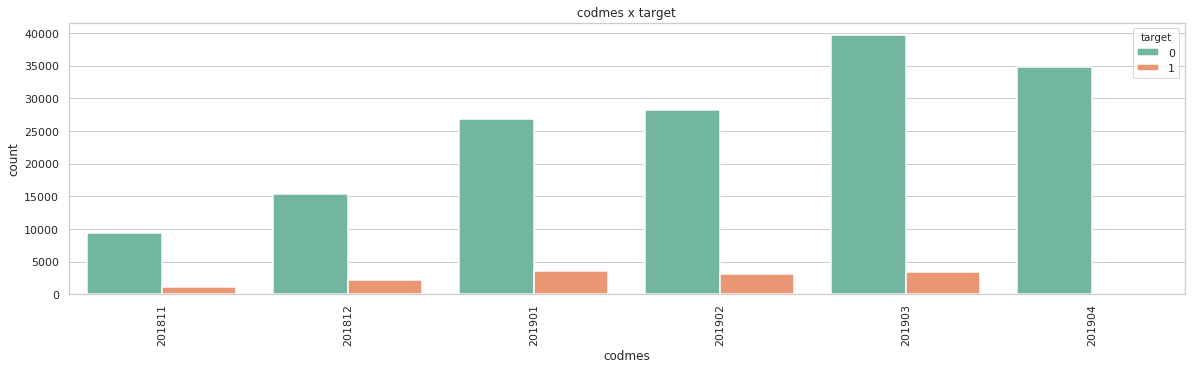

In [35]:
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(20, 5))
ax = sns.countplot(x="codmes",  hue='target',         linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata.sort_values('codmes'))
ax.set_title("codmes x target")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

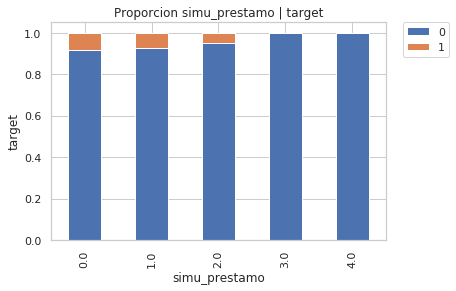

In [74]:
barprop('target', 'simu_prestamo', 'Proporcion simu_prestamo | target', (6,4), rawdata)

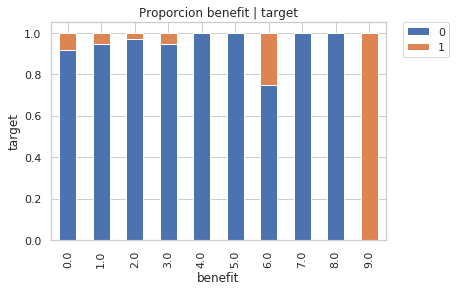

In [75]:
barprop('target', 'benefit', 'Proporcion benefit | target', (6,4), rawdata)

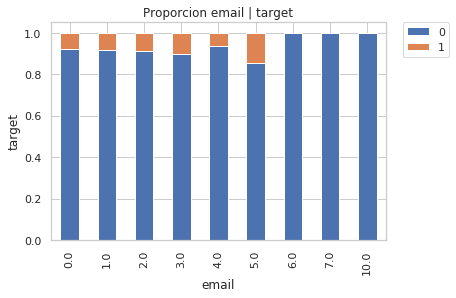

In [76]:
barprop('target', 'email', 'Proporcion email | target', (6,4), rawdata)

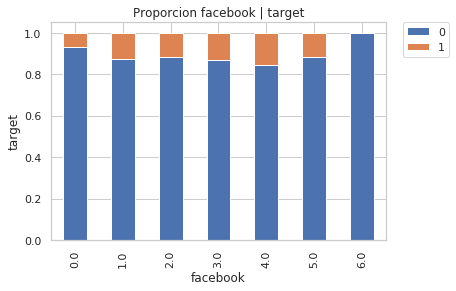

In [78]:
barprop('target', 'facebook', 'Proporcion facebook | target', (6,4), rawdata)

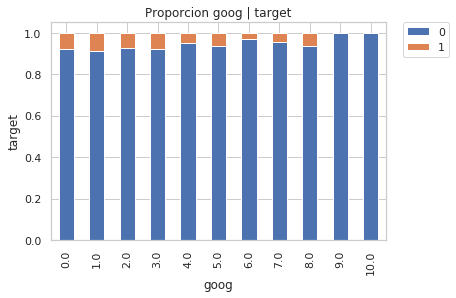

In [79]:
barprop('target', 'goog', 'Proporcion goog | target', (6,4), rawdata)

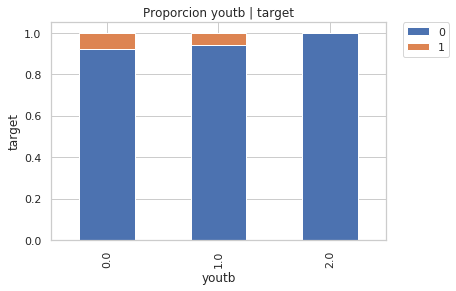

In [80]:
barprop('target', 'youtb', 'Proporcion youtb | target', (6,4), rawdata)

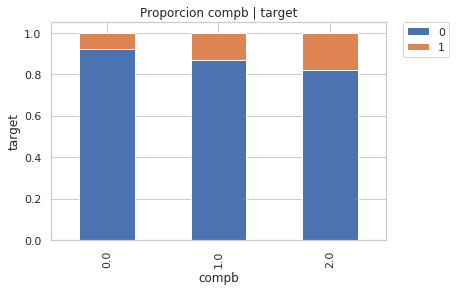

In [81]:
barprop('target', 'compb', 'Proporcion compb | target', (6,4), rawdata)

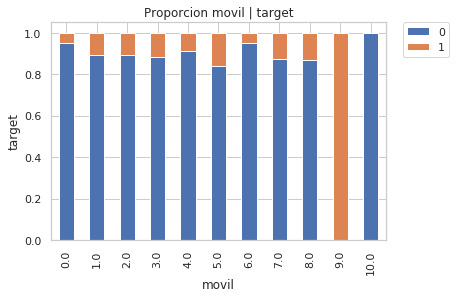

In [82]:
barprop('target', 'movil', 'Proporcion movil | target', (6,4), rawdata)

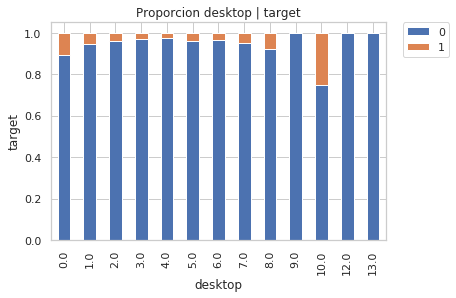

In [83]:
barprop('target', 'desktop', 'Proporcion desktop | target', (6,4), rawdata)

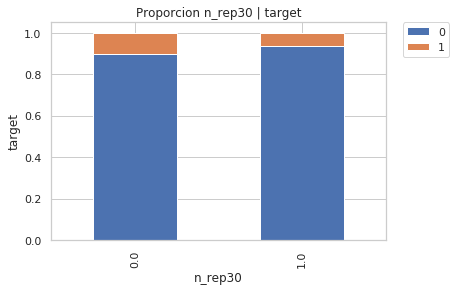

In [84]:
barprop('target', 'n_rep30', 'Proporcion n_rep30 | target', (6,4), rawdata)

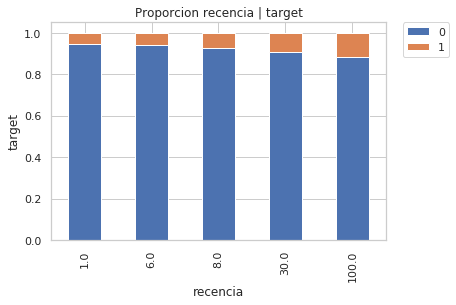

In [85]:
barprop('target', 'recencia', 'Proporcion recencia | target', (6,4), rawdata)

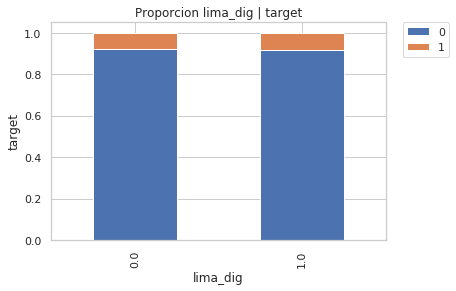

In [86]:
barprop('target', 'lima_dig', 'Proporcion lima_dig | target', (6,4), rawdata)

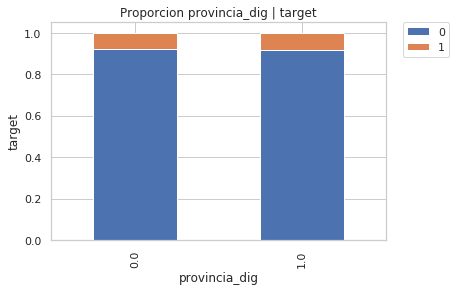

In [87]:
barprop('target', 'provincia_dig', 'Proporcion provincia_dig | target', (6,4), rawdata)

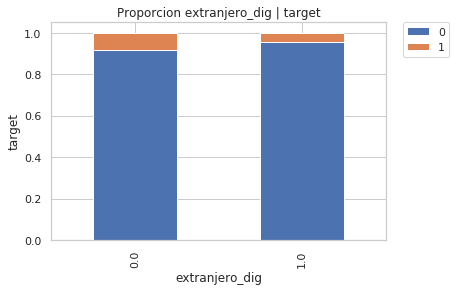

In [88]:
barprop('target', 'extranjero_dig', 'Proporcion extranjero_dig | target', (6,4), rawdata)

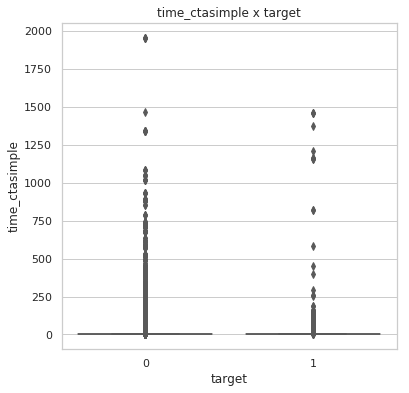

In [92]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="time_ctasimple", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("time_ctasimple x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

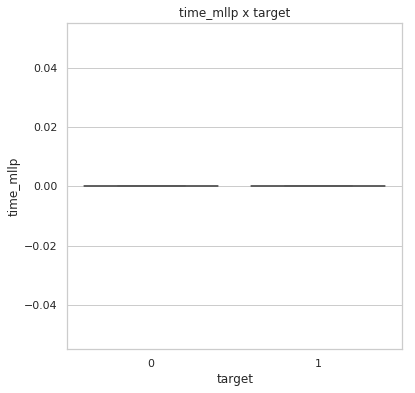

In [93]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="time_mllp", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("time_mllp x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

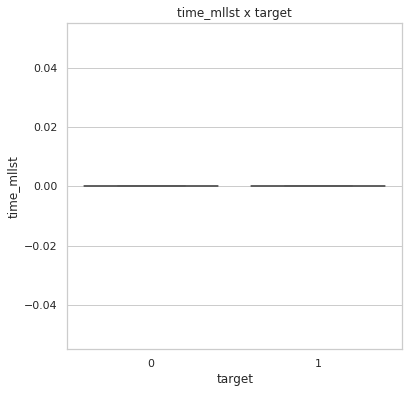

In [94]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="time_mllst", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("time_mllst x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

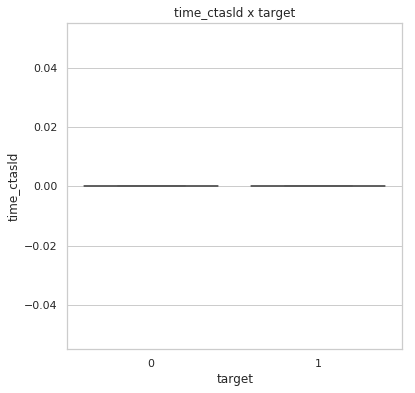

In [95]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="time_ctasld", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("time_ctasld x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

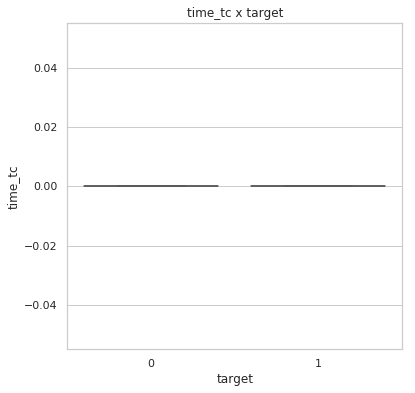

In [96]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="target", y="time_tc", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2", # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("time_tc x target")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

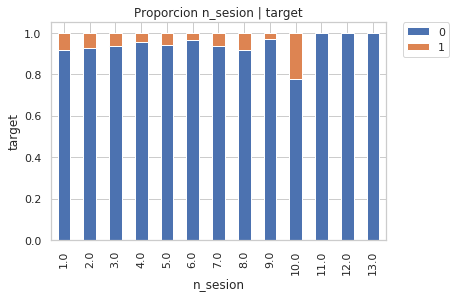

In [97]:
barprop('target', 'n_sesion', 'Proporcion n_sesion | target', (6,4), rawdata)

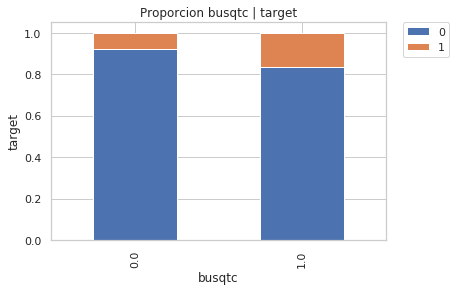

In [98]:
barprop('target', 'busqtc', 'Proporcion busqtc | target', (6,4), rawdata)

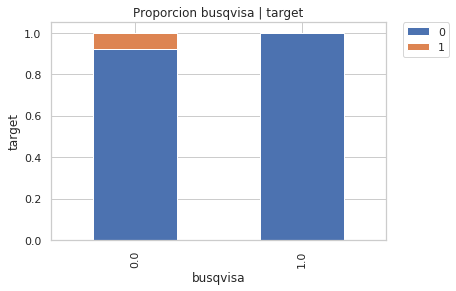

In [99]:
barprop('target', 'busqvisa', 'Proporcion busqvisa | target', (6,4), rawdata)

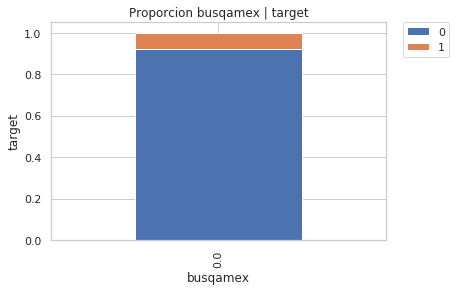

In [100]:
barprop('target', 'busqamex', 'Proporcion busqamex | target', (6,4), rawdata)

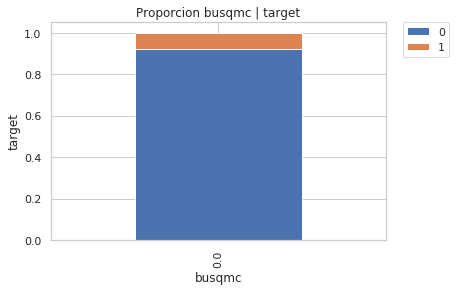

In [101]:
barprop('target', 'busqmc', 'Proporcion busqmc | target', (6,4), rawdata)

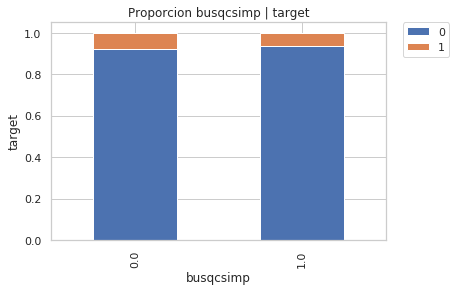

In [103]:
barprop('target', 'busqcsimp', 'Proporcion busqcsimp | target', (6,4), rawdata)

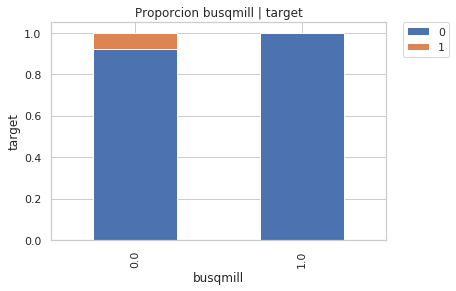

In [107]:
barprop('target', 'busqmill', 'Proporcion busqmill | target', (6,4), rawdata)

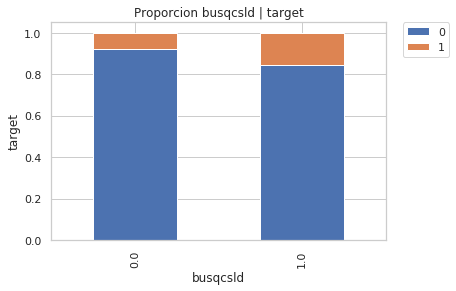

In [108]:
barprop('target', 'busqcsld', 'Proporcion busqcsld | target', (6,4), rawdata)

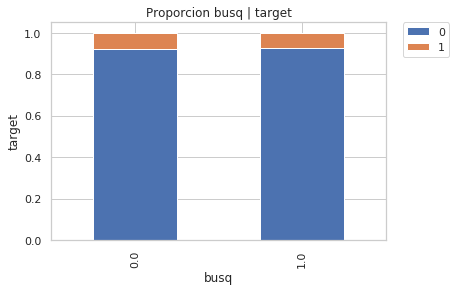

In [109]:
barprop('target', 'busq', 'Proporcion busq | target', (6,4), rawdata)

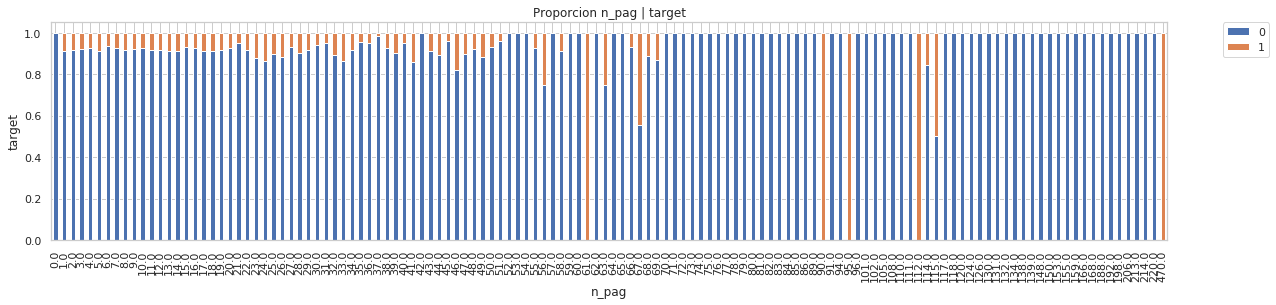

In [112]:
barprop('target', 'n_pag', 'Proporcion n_pag | target', (20,4), rawdata)

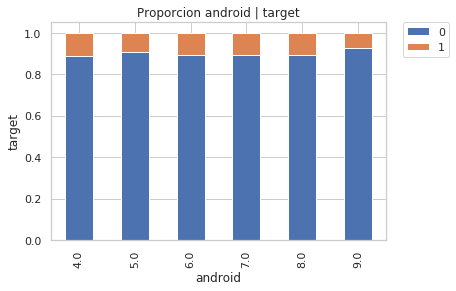

In [113]:
barprop('target', 'android', 'Proporcion android | target', (6,4), rawdata)

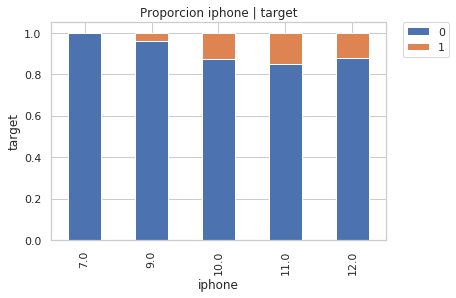

In [114]:
barprop('target', 'iphone', 'Proporcion iphone | target', (6,4), rawdata)